In [36]:
#!pip install category_encoders
#!pip install bayes_opt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.sum_coding import SumEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.helmert import HelmertEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.one_hot import OneHotEncoder
from scipy.special import boxcox1p
#from bayes_opt import BayesianOptimization

In [22]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [23]:
print(train.shape)
train.head()

(150150, 9)


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
record_ID          150150 non-null int64
week               150150 non-null object
store_id           150150 non-null int64
sku_id             150150 non-null int64
total_price        150149 non-null float64
base_price         150150 non-null float64
is_featured_sku    150150 non-null int64
is_display_sku     150150 non-null int64
units_sold         150150 non-null int64
dtypes: float64(2), int64(6), object(1)
memory usage: 10.3+ MB


In [5]:
train.describe()

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,150150.000000,150150.000000,150150.000000,150149.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,106271.555504,9199.422511,254761.132468,206.626751,219.425927,0.095611,0.133200,51.674206
std,61386.037861,615.591445,85547.306447,103.308516,110.961712,0.294058,0.339792,60.207904
min,1.000000,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,1.000000
25%,53111.250000,8562.000000,217217.000000,130.387500,133.237500,0.000000,0.000000,20.000000
50%,106226.500000,9371.000000,222087.000000,198.075000,205.912500,0.000000,0.000000,35.000000
75%,159452.750000,9731.000000,245338.000000,233.700000,234.412500,0.000000,0.000000,62.000000
max,212644.000000,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000,2876.000000


In [7]:
train['units_sold'].describe()

count    150150.000000
mean         51.674206
std          60.207904
min           1.000000
25%          20.000000
50%          35.000000
75%          62.000000
max        2876.000000
Name: units_sold, dtype: float64

In [9]:
train.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

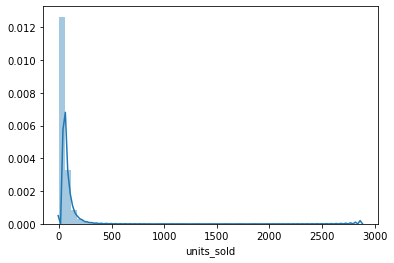

In [10]:
sns.distplot(train["units_sold"])

In [12]:
print("skewness = ", train['units_sold'].skew())

skewness =  6.114995824093101


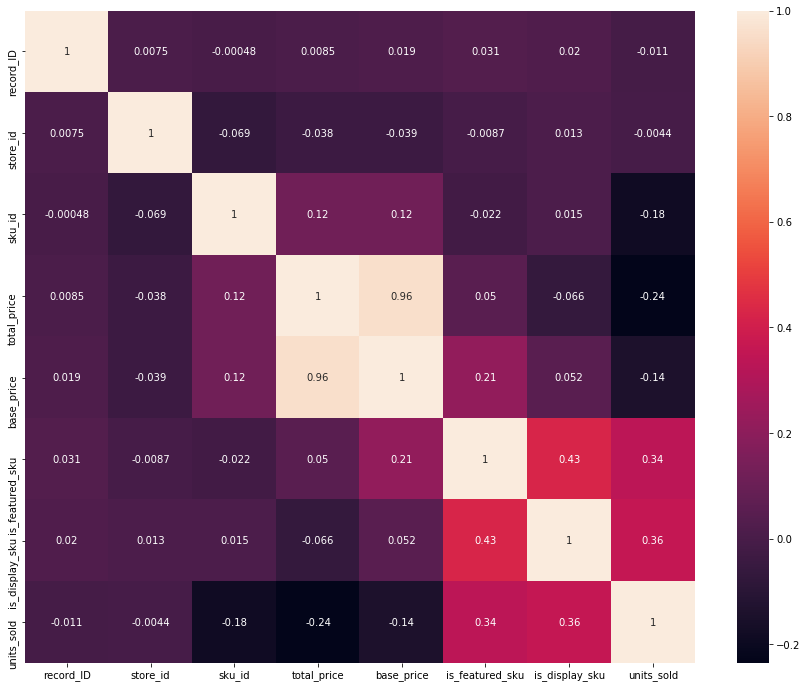

In [17]:
cor = train.corr()
plt.figure(figsize= (15,12))
sns.heatmap(cor, annot = True,)

In [18]:
plt.subplot(1,2)
sns.distplot()
plt.hist()
plt.boxplot()
plt.scatter()

ValueError: Illegal argument(s) to subplot: (1, 2)

<Figure size 432x288 with 0 Axes>

In [20]:
import statsmodels.api as sm 
sm.tsa.seasonal_decompose(Train.units_sold).plot() 
# result = sm.tsa.stattools.adfuller(train.units_sold) 
# plt.show()

In [24]:
#Imputing missing value with the relevant total price
train.total_price=train.total_price.fillna(469.5375)

In [25]:
#New Feature Creation functions

def gen_count_id(train,test,col,name):
    temp=train.groupby(col)['record_ID'].count().reset_index().rename(columns={'record_ID':name})
    train=pd.merge(train,temp,how='left',on=col)
    test=pd.merge(test,temp,how='left',on=col)
    train[name]=train[name].astype(float)
    test[name]=test[name].astype(float)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

def gen_average_units(train,test,col,name):
    temp=train.groupby(col)['units_sold'].mean().reset_index().rename(columns={'units_sold':name})
    train=pd.merge(train,temp,how='left',on=col)
    test=pd.merge(test,temp,how='left',on=col)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

def gen_average_price(train,test,col,price='base_price',name='name'):
    temp=train.groupby(col)[price].mean().reset_index().rename(columns={price:name})
    train=pd.merge(train,temp,how='left',on=col)
    test=pd.merge(test,temp,how='left',on=col)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

In [28]:
train,test = gen_count_id(train,test,col=['sku_id','store_id'],name='count_id_sku_store') #Genearting count of records per 'sku-id & store-id' 
#train,test = gen_count_id(train,test,col=['sku_id','store_id'],name='count_id_sku_store') #Genearting count of records per 'sku-id & store-id' 
train,test = gen_count_id(train,test,col=['sku_id'],name='count_id_sku') #Genearting count of records per 'sku-id'
train,test = gen_count_id(train,test,col=['store_id'],name='count_id_store') #Genearting count of records per 'store-id'

In [30]:
train,test = gen_average_units(train,test,col=['sku_id','store_id'],name='count_sku_store_id') #Genearting average units sold per 'sku-id & store-id'
train,test = gen_average_units(train,test,col=['store_id'],name='count_store_id') #Genearting average units sold per 'store-id'
train,test = gen_average_units(train,test,col=['sku_id'],name='count_sku_id') #Genearting average units sold per 'sku-id'

train,test = gen_average_price(train,test,col=['sku_id','store_id'],price='base_price',name='price_sku_store') #Genearting average base price per 'sku-id & store-id'
train,test = gen_average_price(train,test,col=['sku_id','store_id'],price='total_price',name='price_to_sku_store') #Genearting average total price per 'sku-id & store-id'
train,test = gen_average_price(train,test,col=['store_id'],price='base_price',name='price_store_id') #Genearting average base price per 'store-id'
train,test = gen_average_price(train,test,col=['sku_id'],price='base_price',name='price_sku_id') #Genearting average base price per 'sku-id'
train,test = gen_average_price(train,test,col=['store_id'],price='total_price',name='price_to_store_id') #Genearting average total price per 'store-id'
train,test = gen_average_price(train,test,col=['sku_id'],price='total_price',name='price_to_sku_id') #Genearting average total price per 'sku-id'

In [31]:
train

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,count_id_sku_store,...,count_id_store,count_sku_store_id,count_store_id,count_sku_id,price_sku_store,price_to_sku_store,price_store_id,price_sku_id,price_to_store_id,price_to_sku_id
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20,130.0,...,1170.0,26.376923,32.805983,88.923869,105.800769,102.117692,181.312372,94.688268,172.272756,91.982702
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28,130.0,...,1170.0,28.307692,32.805983,72.182664,105.839135,102.473942,181.312372,94.908763,172.272756,92.349162
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19,130.0,...,1170.0,25.669231,32.805983,34.019231,131.204135,126.671538,181.312372,128.285210,172.272756,125.156355
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44,130.0,...,1170.0,29.107692,32.805983,46.821206,129.916154,126.167308,181.312372,128.101871,172.272756,124.942208
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52,130.0,...,1170.0,29.469231,32.805983,62.312747,164.439519,152.968269,181.312372,158.990538,172.272756,150.867334
5,9,17/01/11,8091,219009,227.2875,227.2875,0,0,18,130.0,...,1170.0,36.300000,32.805983,98.891692,222.935769,207.940385,181.312372,208.554815,172.272756,197.891577
6,10,17/01/11,8091,219029,327.0375,327.0375,0,0,47,130.0,...,1170.0,44.261538,32.805983,47.477661,328.961250,317.917500,181.312372,314.075856,172.272756,301.910425
7,13,17/01/11,8091,223245,210.9000,210.9000,0,0,50,130.0,...,1170.0,37.723077,32.805983,68.510537,217.745481,204.213462,181.312372,214.878438,172.272756,203.073612
8,14,17/01/11,8091,223153,190.2375,234.4125,1,1,82,130.0,...,1170.0,38.038462,32.805983,60.407560,224.969135,209.984712,181.312372,220.461485,172.272756,206.303241
9,17,17/01/11,8095,216418,99.0375,99.0375,0,0,99,130.0,...,2340.0,167.007692,81.742308,88.923869,103.602981,101.131154,225.480369,94.688268,210.667067,91.982702


In [37]:
#Converting week feature
le = OrdinalEncoder()
train['week_1']=le.fit_transform(train['week'])
le = OrdinalEncoder()
test['week_1']=le.fit_transform(test['week'])+130

In [38]:
train

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,count_id_sku_store,...,count_sku_store_id,count_store_id,count_sku_id,price_sku_store,price_to_sku_store,price_store_id,price_sku_id,price_to_store_id,price_to_sku_id,week_1
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20,130.0,...,26.376923,32.805983,88.923869,105.800769,102.117692,181.312372,94.688268,172.272756,91.982702,1
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28,130.0,...,28.307692,32.805983,72.182664,105.839135,102.473942,181.312372,94.908763,172.272756,92.349162,1
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19,130.0,...,25.669231,32.805983,34.019231,131.204135,126.671538,181.312372,128.285210,172.272756,125.156355,1
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44,130.0,...,29.107692,32.805983,46.821206,129.916154,126.167308,181.312372,128.101871,172.272756,124.942208,1
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52,130.0,...,29.469231,32.805983,62.312747,164.439519,152.968269,181.312372,158.990538,172.272756,150.867334,1
5,9,17/01/11,8091,219009,227.2875,227.2875,0,0,18,130.0,...,36.300000,32.805983,98.891692,222.935769,207.940385,181.312372,208.554815,172.272756,197.891577,1
6,10,17/01/11,8091,219029,327.0375,327.0375,0,0,47,130.0,...,44.261538,32.805983,47.477661,328.961250,317.917500,181.312372,314.075856,172.272756,301.910425,1
7,13,17/01/11,8091,223245,210.9000,210.9000,0,0,50,130.0,...,37.723077,32.805983,68.510537,217.745481,204.213462,181.312372,214.878438,172.272756,203.073612,1
8,14,17/01/11,8091,223153,190.2375,234.4125,1,1,82,130.0,...,38.038462,32.805983,60.407560,224.969135,209.984712,181.312372,220.461485,172.272756,206.303241,1
9,17,17/01/11,8095,216418,99.0375,99.0375,0,0,99,130.0,...,167.007692,81.742308,88.923869,103.602981,101.131154,225.480369,94.688268,210.667067,91.982702,1
